Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  It shares the same image size and structure of training and testing splits.

- ## Try to build a classifier for the Fashion-MNIST dataset that achieves over 85% accuracy on the test set. 
- ## Use only classifiers that are used in the Chapter 3 of the textbook.
- ## Do the error analysis following the textbook.

In [2]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('', kind='train')
X_test, y_test = mnist_reader.load_mnist('', kind='t10k')

In [4]:
X_train.shape

(60000, 784)

In [5]:
y_train.shape

(60000,)

### Labels
Each training and test example is assigned to one of the following labels:

Label	Description
- 0	T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

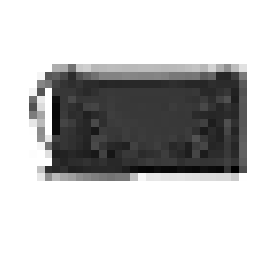

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X_train[36001]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off");

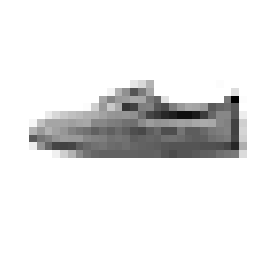

In [8]:
plot_digit(X_train[40000])

In [9]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

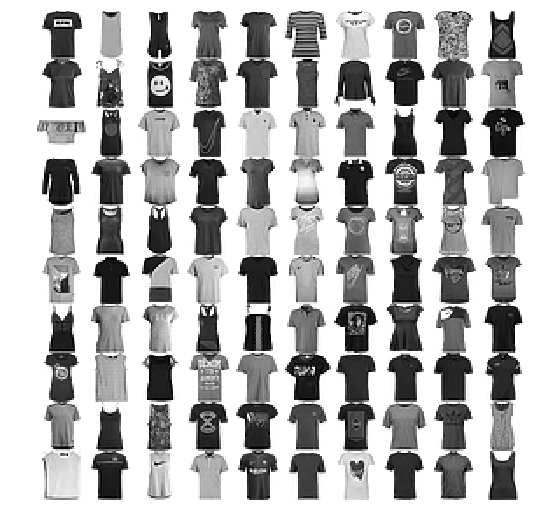

In [10]:
plt.figure(figsize=(9,9))
X_0 = X_train[(y_train == 0)]
example_images = X_0[:100]
plot_digits(example_images, images_per_row=10)

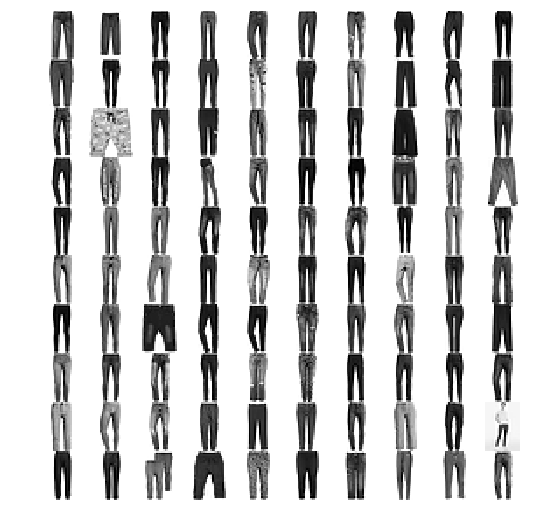

In [11]:
plt.figure(figsize=(9,9))
X_1 = X_train[(y_train == 1)]
example_images = X_1[:100]
plot_digits(example_images, images_per_row=10)

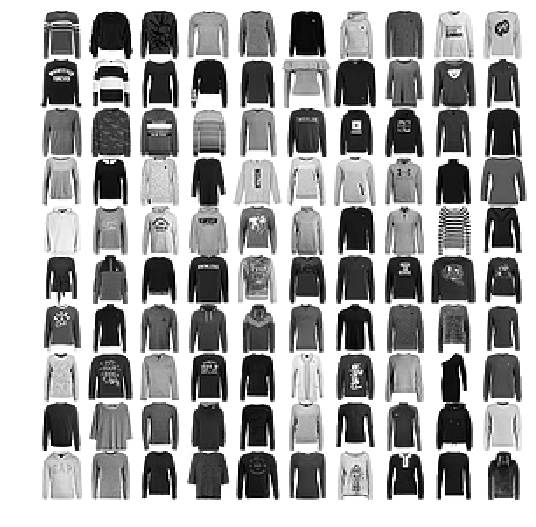

In [12]:
plt.figure(figsize=(9,9))
X_2 = X_train[(y_train == 2)]
example_images = X_2[:100]
plot_digits(example_images, images_per_row=10)

# Plan 

Here's what I intend to do:

1. Train the following models on the data 
    - SGDClassifier
    - RandomForestClassifier
    - OneVsOneClassifier
    - OneVsRestClassifier
2. Error Analysis
3. Optimization 

In [13]:
#Import classifiers
from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.multiclass import (OneVsOneClassifier as OVO, OneVsRestClassifier as OVR) 
print(SGDC, RFC, OVO, OVR) #NOTE: I will refer to the classifiers by these names for the rest of this notebook. 

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> <class 'sklearn.ensemble.forest.RandomForestClassifier'> <class 'sklearn.multiclass.OneVsOneClassifier'> <class 'sklearn.multiclass.OneVsRestClassifier'>


# Plans for Error: 

To calculate error, I'll be using diffrent metrics for diffrent classifiers. e.g, with OVO I will use a Precision/Recall curve, becasue positive IDs are rare in comparison to negitive ones. 

In most cases, though I'll end up using ROC AUC. 

In [14]:
random_seed = 42
SGD_Cls = SGDC(random_state=random_seed, max_iter=5, tol=None) #These two params silence warnings. 
RF_Cls = RFC(random_state=random_seed)
SGD_Cls

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [15]:
y_train_trouser = (y_train == 1 )

#Find a random true instance and see what our model claims, what the label says and what I think the ans is. 
for i in range(len(y_train_trouser)):
    if y_train_trouser[i] == True:
        break;

print(y_train_trouser[i:i+30])

[ True False False False False  True False False False False False False
 False False False False False False False False False False  True False
 False False False False False False]


I checked a random subsection of the training data to make sure that it's not all grouped together, and it looks good. The output looks like it's sorted. If it wasn't we'd just have a block of "True"

I'll shuffle anyway though, just to be safe. 

In [16]:
shuffle_index = np.random.RandomState(seed=random_seed).permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [17]:
SGD_Cls.fit(X_train, y_train_trouser)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

[False]


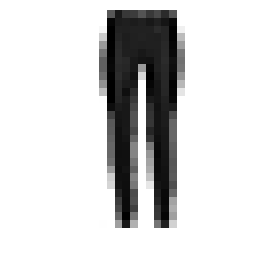

In [18]:
plot_digit(X_train[i])
print(SGD_Cls.predict([X_train[i]]))

In [19]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

cross_val_score(SGD_Cls, X_train, y_train_trouser, cv=5, scoring="accuracy")

array([0.89641667, 0.89783333, 0.89075   , 0.89283333, 0.87208333])

This is pretty high. But as we learned in class, this is not a really good mesure of this model. 

In [20]:
y_t_p = cross_val_predict(SGD_Cls, X_train, y_train_trouser, cv=5)

In [21]:
confusion_matrix(y_train_trouser, y_t_p)

array([[53311,   689],
       [ 5912,    88]])

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(y_train_trouser, y_t_p))
print(precision_score(y_train_trouser, y_t_p))
print(recall_score(y_train_trouser, y_t_p))

0.025970193300870595
0.11325611325611326
0.014666666666666666


These scores are really bad.

Note that I went with F1 score here. This is due to the fact that the positive class (trousers) is actually pretty rare in comparison to the rest of the data set. In cases where our data set has a more even split, ROC AUC makes more sense. 

Something intresting that I noticed is that the first time around I forgot to shuffle and got 99% accuracy. This is intresting. 

The main thing that this classifier seems to be really bad at is figuring out true positive values. (88 identified...)

In [23]:
sum([1 for v in y_train_trouser if v])

6000

Looks like 1/10th of our data set is trousers. The TP rate should really be in the high 5000s. If I were to guess, based on what we learned about gradient decent, it takes MUCH more data than what we have to acutally make the predictor become accurate. 

I may try constructing a better dataset using a subset of what I have here. Better meaning it's 50% trousers and 50% everything else.


In [24]:
X_train_special = np.concatenate((X_train[(y_train_trouser == True)], X_train[(y_train_trouser == False)][:6000]))
y_train_special = np.concatenate((y_train[(y_train_trouser==True)], y_train[(y_train_trouser == False)][:6000]))
shuffle_special = np.random.permutation(12000)
X_train_special, y_train_special = X_train_special[shuffle_special], y_train_special[shuffle_special] 

1


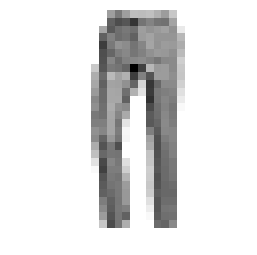

In [25]:
plot_digit(X_train_special[55])
print(y_train_special[55])

#Based on the output this is fine. 

In [26]:
#WARNING SLOW
SGD_Cls = SGDC(random_state=random_seed, max_iter=5, tol=None)
y_train_special_fittable = (y_train_special == 1)
SGD_Cls.fit(X_train_special, y_train_special_fittable)

y_t_p_s = cross_val_predict(SGD_Cls, X_train_special, y_train_special_fittable, cv=3)

In [27]:
print(confusion_matrix(y_train_special_fittable, y_t_p_s))
print(f1_score(y_train_special_fittable, y_t_p_s))
print(precision_score(y_train_special_fittable, y_t_p_s))
print(recall_score(y_train_special_fittable, y_t_p_s))

[[10711   111]
 [   49  1129]]
0.9338296112489661
0.910483870967742
0.9584040747028862


In [28]:
from numpy.random import randint

r_ind = randint(20, high=len(X_train))
random_group_x, random_group_y = X_train[r_ind:r_ind+300], y_train[r_ind:r_ind+300]

v = SGD_Cls.predict(random_group_x)

print(sum([1 for i in range(len(random_group_x)) if random_group_y[i] == v[i]]))
print(sum([1 for v in random_group_y if (v == 1)]))

61
36


The F1 score seems to say that this model fairs much better. (Of course, this is on a skewed data set. My simple sum based comparison, which takes a model fitted on the 50/50 data set and tests it on the true dataset seems to show that this really wouldn't be too much better. 

I think at this point I'll test the next model. 

Note I may go for a group classifier and see if that works any better. 


## RandomForestClassifier (RFC)

In [29]:
#WARNING SLOW
RF_C_y_preds = cross_val_predict(RF_Cls, X_train, y_train_trouser, cv=3)
print(confusion_matrix(y_train_trouser, RF_C_y_preds))
print(f1_score(y_train_trouser, RF_C_y_preds))
print(precision_score(y_train_trouser, RF_C_y_preds))
print(recall_score(y_train_trouser, RF_C_y_preds))


[[53834   166]
 [ 5979    21]]
0.006788427347664458
0.11229946524064172
0.0035


In [30]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_trouser, RF_C_y_preds))

0.500212962962963


This thing might as well just be a random number generator. 

I'll try with multiple classes instead. 

I think it makes sense that binary classifiers are really hard to use with this dataset. Coats and Tops sometimes look very simmilar. Same with ankle boots and sneakers.

Some sneakers may even get confused with handbags, because sneakers tend to be a big block, and handbags follow a simmilar trend. 

In [31]:
#WARNING SLOW
RF_C_y_pred_multiclass = cross_val_predict(RF_Cls, X_train, y_train, cv=3)

In [32]:
print(confusion_matrix(y_train, RF_C_y_pred_multiclass))
print(f1_score(y_train, RF_C_y_pred_multiclass, average="micro"))
print(precision_score(y_train, RF_C_y_pred_multiclass, average="micro"))
print(recall_score(y_train, RF_C_y_pred_multiclass, average="micro"))

[[5111    5   94  201   33    4  503    0   49    0]
 [  33 5795   16  120   11    1   23    0    1    0]
 [  82    4 4780   53  694    1  349    0   37    0]
 [ 207   61   71 5349  178    1  122    0   11    0]
 [  34   11  734  300 4591    0  310    0   19    1]
 [   1    1    0    4    0 5678    2  208   25   81]
 [1093   10  793  184  626    3 3205    1   85    0]
 [   0    0    0    0    0  195    0 5532    9  264]
 [  19    3   42   26   36   31   64   15 5760    4]
 [   3    0    0    5    1   74    4  261   11 5641]]
0.8573666666666667
0.8573666666666667
0.8573666666666667


This worked VERY well in comparison to binary classification. 

Just eyeballing the matrix there seems to be some problem areas though. It seems like sneakers and t_shirts are a bit confusing to the classifier. 

A bit unexpected. I'll keep this classifier on the list.

I'm going to look at this matrix in a bit more detail, then move to doing the next model. I'll use a gird search (Or maybe a random search) on the model that I think works out best. I may do both in the event that they are very close in performance. 

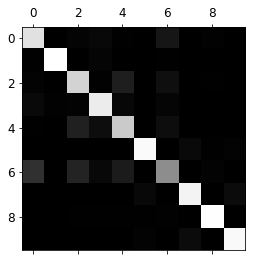

In [33]:
plt.matshow(confusion_matrix(y_train, RF_C_y_pred_multiclass), cmap=plt.cm.gray)

As expected, 6,0 is problematic. I'm going to zero out the diagonal now though. 

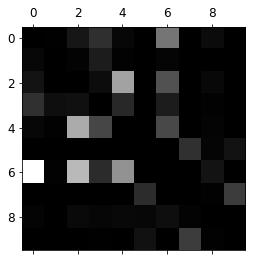

In [34]:
c_matrix = confusion_matrix(y_train, RF_C_y_pred_multiclass)
for i in range(len(c_matrix)):
    c_matrix[i][i] = 0

plt.matshow(c_matrix, cmap=plt.cm.gray)

# One Vs Rest (OVR) 

I'll train and check the error on this model. 

In [35]:
#WARNING SLOW
OVR_Cls_SGD_estimator = OVR(SGD_Cls)
OVR_y_pred_SGD = cross_val_predict(OVR_Cls_SGD_estimator, X_train, y_train, cv=3)

0.8008
0.8008
0.8008


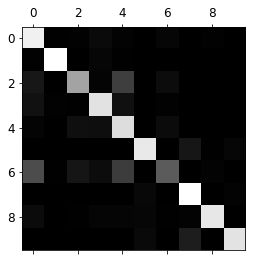

In [36]:
c_mat_ovr_cls_SGD_estimator = confusion_matrix(y_train, OVR_y_pred_SGD)
plt.matshow(c_mat_ovr_cls_SGD_estimator, cmap=plt.cm.gray)

print(f1_score(y_train, OVR_y_pred_SGD, average="micro"))
print(precision_score(y_train, OVR_y_pred_SGD, average="micro"))
print(recall_score(y_train, OVR_y_pred_SGD, average="micro"))

Theoretically worse than RFC. Though I suppose that that's to be expected. 

In [37]:
#WARNING VERY SLOW. Just don't run this one. 
OVR_Cls_RFC_estimator = OVR(RF_Cls)
OVR_y_pred_RFC = cross_val_predict(OVR_Cls_RFC_estimator, X_train, y_train, cv=3)

0.8655166666666667
0.8655166666666667
0.8655166666666667


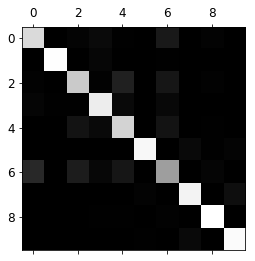

In [38]:
c_mat_ovr_cls_RFC_estimator = confusion_matrix(y_train, OVR_y_pred_RFC)
plt.matshow(c_mat_ovr_cls_RFC_estimator, cmap=plt.cm.gray)

print(f1_score(y_train, OVR_y_pred_RFC, average="micro"))
print(precision_score(y_train, OVR_y_pred_RFC, average="micro"))
print(recall_score(y_train, OVR_y_pred_RFC, average="micro"))

This one was slow to cross validate, but it did better. nearly .87.

# OneVsOne

I'll skip dealing with SGD. We already know that it's pretty poor all told. I'll just make one to deal with RFC, and compare what the result is. 

In [39]:
OVO_Cls_RFC_estimator = OVO(RF_Cls)
OVO_y_pred_RFC_estimator = cross_val_predict(OVO_Cls_RFC_estimator, X_train, y_train, cv=3)

0.8586833333333334
0.8586833333333334
0.8586833333333334


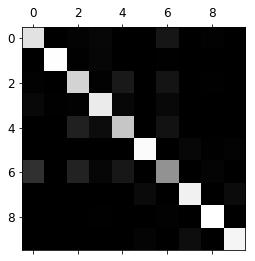

In [40]:
c_mat_ovo_cls_RFC_estimator = confusion_matrix(y_train, OVO_y_pred_RFC_estimator)
plt.matshow(c_mat_ovo_cls_RFC_estimator, cmap=plt.cm.gray)

print(f1_score(y_train, OVO_y_pred_RFC_estimator, average="micro"))
print(precision_score(y_train, OVO_y_pred_RFC_estimator, average="micro"))
print(recall_score(y_train, OVO_y_pred_RFC_estimator, average="micro"))

This looks like it faired mildly better than the RFC on its own. 

# Search Based Optimization of RFC

I'll try to make an improvement to the results given by RFC by searching. I will skip OVO and OVR because they have only one real param that matters.

In [41]:
from sklearn.model_selection import RandomizedSearchCV as RSCV

'''
Params and their defaults 

I won't touch warm start because I think that will overfit if it's true. 

n_estimators=10, 
criterion=’gini’,
max_depth=None, 
min_samples_split=2, 
min_samples_leaf=1, 
min_weight_fraction_leaf=0.0, 
max_features=’auto’, 
max_leaf_nodes=None,
min_impurity_decrease=0.0, 
min_impurity_split=None, 
bootstrap=True, 
oob_score=False 
'''

param_set_RFC = { 
    'n_estimators':[10,11,12],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2],
    'max_features':[None, 'sqrt', 'log2']
}

In [58]:
#VERY SLOW This took 38 mins to run. 
search_res = RSCV(RF_Cls, param_set_RFC, scoring="f1_micro", cv=3, verbose=4).fit(X_train, y_train)
best_score = search_res.best_score_
best_score

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=11, min_samples_split=2, min_samples_leaf=2, max_features=None 
[CV]  n_estimators=11, min_samples_split=2, min_samples_leaf=2, max_features=None, score=0.8631, total= 3.1min
[CV] n_estimators=11, min_samples_split=2, min_samples_leaf=2, max_features=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV]  n_estimators=11, min_samples_split=2, min_samples_leaf=2, max_features=None, score=0.85865, total= 3.2min
[CV] n_estimators=11, min_samples_split=2, min_samples_leaf=2, max_features=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.3min remaining:    0.0s


[CV]  n_estimators=11, min_samples_split=2, min_samples_leaf=2, max_features=None, score=0.85255, total= 3.1min
[CV] n_estimators=12, min_samples_split=3, min_samples_leaf=2, max_features=None 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.4min remaining:    0.0s


[CV]  n_estimators=12, min_samples_split=3, min_samples_leaf=2, max_features=None, score=0.864, total= 3.2min
[CV] n_estimators=12, min_samples_split=3, min_samples_leaf=2, max_features=None 
[CV]  n_estimators=12, min_samples_split=3, min_samples_leaf=2, max_features=None, score=0.85965, total= 3.2min
[CV] n_estimators=12, min_samples_split=3, min_samples_leaf=2, max_features=None 
[CV]  n_estimators=12, min_samples_split=3, min_samples_leaf=2, max_features=None, score=0.8537, total= 3.3min
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=None 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=None, score=0.8564, total= 2.9min
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=None 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=None, score=0.8553, total= 3.1min
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=None 
[CV]  n_estimators=10, min_samples_

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 38.2min finished


0.8613

In [59]:
search_res.best_params_

#Output noted here just in case. 
# {'n_estimators': 11,
#  'min_samples_split': 4,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt'}

{'n_estimators': 11,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

# We build an OVR estimator using the optimized RFC 


In [60]:
RF_optimized = search_res.best_estimator_

OVR_Cls_RFC_estimator_optimized = OVR(RF_optimized)
OVR_y_pred_RFC_optimized = cross_val_predict(OVR_Cls_RFC_estimator_optimized, X_train, y_train, cv=3)

0.8679333333333333
0.8679333333333333
0.8679333333333333


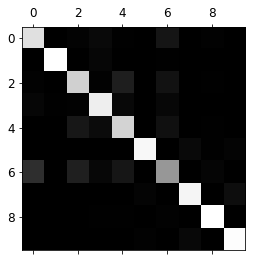

In [61]:
c_mat_ovr_cls_RFC_estimator_optimized = confusion_matrix(y_train, OVR_y_pred_RFC_optimized)
plt.matshow(c_mat_ovr_cls_RFC_estimator_optimized, cmap=plt.cm.gray)

print(f1_score(y_train, OVR_y_pred_RFC_optimized, average="micro"))
print(precision_score(y_train, OVR_y_pred_RFC_optimized, average="micro"))
print(recall_score(y_train, OVR_y_pred_RFC_optimized, average="micro"))

This is slightly better. The only thing left is to try k nearest neighbors 

# K nearest neighbors 

In [64]:
from sklearn.neighbors import KNeighborsClassifier as KNC

k_cls = KNC()
k_n_y_pred = cross_val_predict(k_cls, X_train, y_train)

0.8523
0.8523
0.8523


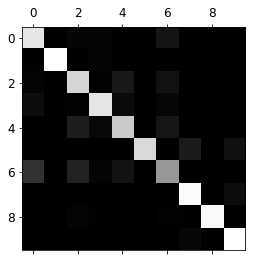

In [65]:
k_n_mat = confusion_matrix(y_train, k_n_y_pred)
plt.matshow(k_n_mat, cmap=plt.cm.gray)

print(f1_score(y_train, k_n_y_pred, average="micro"))
print(precision_score(y_train, k_n_y_pred, average="micro"))
print(recall_score(y_train, k_n_y_pred, average="micro"))

This is about the same as the RFC. I'm not going to try and optimize this. Searching over an amount of terms will take well over 2 hrs. 


At this point I'll try the OVR with optimized RFC on my test set to see what the result is. 

In [68]:
OVR_Cls_RFC_estimator_optimized.fit(X_train, y_train)
test_pred = OVR_Cls_RFC_estimator_optimized.predict(X_test)
test_pred_mat = confusion_matrix(y_test, test_pred)

0.8636
0.8636
0.8636


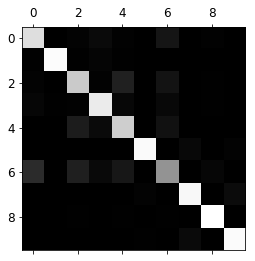

In [69]:
plt.matshow(test_pred_mat, cmap=plt.cm.gray)

print(f1_score(y_test, test_pred, average="micro"))
print(precision_score(y_test, test_pred, average="micro"))
print(recall_score(y_test, test_pred, average="micro"))

# Attempt to improve through true random search

In [45]:
from scipy.stats import randint

param_set_RFC_v2 = { 
    'n_estimators':randint(low=10, high=25),
    'min_samples_split':randint(low=2, high=7),
    'min_samples_leaf':[1,2],
    'max_features':[None, 'sqrt', 'log2']
}

In [50]:
#This is pretty slow as well.  
search_res_v2 = RSCV(RF_Cls, param_set_RFC_v2, scoring="f1_micro", cv=3, verbose=7, n_jobs=3).fit(X_train, y_train)
best_score_v2 = search_res_v2.best_score_
best_score_v2

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11 
[CV] max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11 
[CV] max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11 
[CV]  max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11, score=0.8531, total=   3.1s
[CV] max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=23 
[CV]  max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11, score=0.8544, total=   3.4s
[CV] max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=23 


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    4.0s


[CV]  max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11, score=0.8486, total=   3.4s
[CV] max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=23 
[CV]  max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=23, score=0.8642, total=   6.4s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=18 
[CV]  max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=23, score=0.8646999999999999, total=   6.8s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=18 
[CV]  max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=23, score=0.86515, total=   7.7s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=18 
[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=18, score=0.86895, total=  15.0s
[CV] max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=11 
[CV]  max_features=sq

[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 17.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 17.4min finished


0.8694166666666666

In [49]:
best_score_v2 = search_res_v2.best_score_
best_score_v2

0.8683833333333333

We got 86! Overall this model works well

# Conclusion:

I think that I should have written a bunch of functions to automate a lot of this testing. I was calculating percision, recall and f1 multiple times. I was also using matshow alot. 

What I should have done is just ran a random search on my models, and then a grid search on the best models from the output. The result would be a whole pipeline. 